# 0. Import and Load

In [35]:
import pandas as pd
import numpy as np
import catboost
from sklearn.model_selection import train_test_split, KFold
import datetime
import matplotlib.pyplot as plt
import pickle

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()

In [36]:
import plotly.io as pio
pio.renderers.default = 'iframe'

In [37]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('output/final_dataset.csv').drop('price', axis=1)

# 1. Date Preprocessing

In [4]:
df.rename(columns={'dt':'post_dt'}, inplace=True)
dt_cols = [*[col for col in df.columns if col.startswith('first_dt')], 'post_dt', 'available_date']
df[dt_cols] = df[dt_cols].applymap(pd.to_datetime)

In [5]:
cat_num_cols = []
for col in dt_cols:
    df[f'{col}_year'] = df[col].dt.year
    df[f'{col}_month'] = df[col].dt.month
    df[f'{col}_day'] = df[col].dt.day
    df[f'{col}_day_of_week'] = df[col].dt.day_of_week
    df[f'{col}_week'] = df[col].dt.week
    df[f'{col}_oldness'] = (df[col].max() - df[col]).map(lambda x: x.days)
    cat_num_cols.extend([f"{col}_{comp}" for comp in ['year', 'month', 'day', 'day_of_week', 'week']])
    df.drop(col, axis=1, inplace=True)

# 2. Column selection

In [6]:
cat_cols = [
    'type',
    'city',
    'complex',
    'district',
    'house_number',
    'microdistrict',
    'okrug',
    'partnership',
    'settlement',
    'street',
    'locator_class',
    'locator_osm_type',
    'locator_type',
    'post_index',
    'school_0_id',
    'school_0_forma',
    'school_0_type',
    'school_1_id',
    'school_1_forma',
    'school_1_type',
    'school_2_id',
    'school_2_forma',
    'school_2_type',
    'first_cat_architectural_monument_status',
    'first_cat_money_collecting_way',
    'first_cat_comment',
    'second_cat_project_type',
    'second_cat_house_type',
    'second_cat_is_alarm',
    'second_cat_method_of_forming_overhaul_fund',
    'second_cat_energy_efficiency',
    'second_cat_other_beautification',
    'second_cat_foundation_type',
    'second_cat_floor_type',
    'second_cat_wall_material',
    'second_cat_chute_type',
    'second_cat_electrical_type',
    'second_cat_heating_type',
    'second_cat_hot_water_type',
    'second_cat_cold_water_type',
    'second_cat_sewerage_type',
    'second_cat_gas_type',
    'second_cat_ventilation_type',
    'second_cat_firefighting_type',
    'second_cat_drainage_type',
]
num_cols = [col for col in df.columns if not (col in cat_cols)]

In [7]:
df.loc[:, [f"cat_{col}" for col in cat_num_cols]] = df[cat_num_cols]
cat_cols.extend([f"cat_{col}" for col in cat_num_cols])

In [8]:
df_cols = [*num_cols, *cat_cols]
df = df[df_cols]

df[num_cols] = df[num_cols].astype(float)
df[cat_cols] = df[cat_cols].astype(str)

# 3. Price per metr filtration

In [10]:
def get_low_up_bound(series, out_ratio):
    lower_quantile = out_ratio / 2
    upper_quantile = 1 - lower_quantile

    low_bound = series.quantile(lower_quantile)
    up_bound = series.quantile(upper_quantile)
    return low_bound, up_bound

def filter_price_metr(val, low_bound, up_bound):
    return  pd.isna(val) or (low_bound<=val<=up_bound)

<AxesSubplot: >

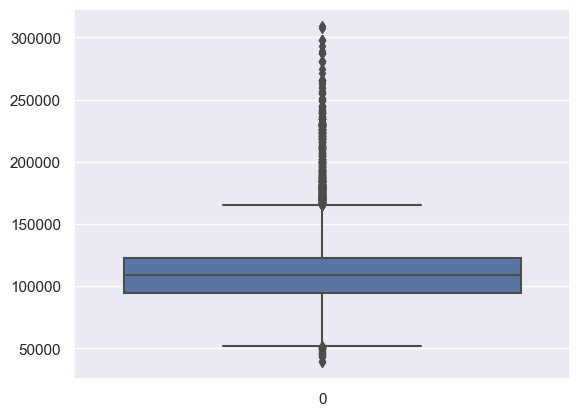

In [11]:
low_bound, up_bound = get_low_up_bound(df['price_per_metr'], 0.001)
adj_filter_price_metr = lambda x: filter_price_metr(x, low_bound, up_bound)
sns.boxplot(df[df['price_per_metr'].map(adj_filter_price_metr)]['price_per_metr'])

In [12]:
df = df[df['price_per_metr'].map(adj_filter_price_metr)].reset_index(drop=True)

In [13]:
num_cols.remove('price_per_metr')

# 4. NA filling

In [14]:
df.fillna(df[num_cols].median(), inplace=True)

# 5. Train and Test preprocessing

In [15]:
zero_feats = [
    'cat_first_dt_exclude_date_from_program_day_of_week',
    'cat_first_dt_exclude_date_from_program_week',
    'cat_first_dt_exclude_date_from_program_month',
    'cat_first_dt_money_collecting_way_date_decision_month',
    'cat_first_dt_exclude_date_from_program_year',
    'cat_first_dt_money_collecting_way_date_decision_day',
    'cat_available_date_day',
    'cat_first_dt_alarm_document_date_year',
    'cat_available_date_month',
    'cat_first_dt_alarm_document_date_week',
    'cat_first_dt_alarm_document_date_month',
    'cat_first_dt_alarm_document_date_day_of_week',
    'cat_first_dt_alarm_document_date_day',
    'cat_available_date_year',
    'cat_available_date_week',
    'cat_first_dt_money_collecting_way_date_decision_day_of_week',
    'cat_available_date_day_of_week',
    'cat_first_dt_money_ppl_collected_date_day_of_week',
    'cat_first_dt_exclude_date_from_program_day',
    'cat_first_dt_money_ppl_collected_date_month',
    'cat_first_dt_money_ppl_collected_date_week',
    'cat_first_dt_money_ppl_collected_date_year',
    'cat_first_dt_money_collecting_way_date_decision_year',
    'first_dt_alarm_document_date_month',
    'first_dt_alarm_document_date_day_of_week',
    'post_dt_year',
    'cat_first_dt_money_ppl_collected_date_day',
    'cat_post_dt_week',
    'cat_post_dt_month',
    'cat_post_dt_day_of_week',
    'cat_post_dt_day',
    'cat_post_dt_year',
    'cat_first_dt_money_collecting_way_date_decision_week',
]

once_zero_feats = [
    'first_dt_alarm_document_date_week',
    'first_dt_alarm_document_date_year',
    'first_dt_exclude_date_from_program_year',
]

In [16]:
redundant_feats = [
    *zero_feats,
    *once_zero_feats
]
cat_cols = list(set(cat_cols).difference(redundant_feats))
num_cols = list(set(num_cols).difference(redundant_feats))


df.drop(redundant_feats, axis=1, inplace=True)

In [17]:
x, y = df.drop('price_per_metr', axis=1), df['price_per_metr']

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=108)

# 6. Model learning

In [21]:
class KFoldCatBoostRegressor:
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.kfold = KFold(n_splits=5, shuffle=True, random_state=108)
    
    def fit(self, x_train, y_train, **fit_kwargs):
        self.regressors = []
        
        for train_idx, valid_idx in self.kfold.split(x_train):
            regressor = catboost.CatBoostRegressor(**self.kwargs)

            regressor.fit(
                x_train.iloc[train_idx],
                y_train.iloc[train_idx],
                eval_set=(x_train.iloc[valid_idx], y_train.iloc[valid_idx]),
            )
            self.regressors.append(regressor)
    
    def predict(self, x):
        return sum([model.predict(x) for model in self.regressors]) / len(self.regressors)
    
    def get_feature_importance(self):
        return (
            sum(
                [col.get_feature_importance(prettified=True).set_index('Feature Id') for col in self.regressors]
            )/6
        ).sort_values('Importances')

In [22]:
kfold_catboost_reg = KFoldCatBoostRegressor(
    random_seed=108,
    use_best_model=True,
    eval_metric='RMSE',
    cat_features=cat_cols,
    num_trees=10000,
    metric_period=100,
)

In [23]:
kfold_catboost_reg.fit(x_train, y_train, plot=True)

Learning rate set to 0.016432
0:	learn: 28271.0226258	test: 26173.1558878	best: 26173.1558878 (0)	total: 228ms	remaining: 37m 59s
100:	learn: 19243.3406732	test: 17828.2607011	best: 17828.2607011 (100)	total: 8.96s	remaining: 14m 38s
200:	learn: 17095.5801161	test: 16216.4526535	best: 16216.4526535 (200)	total: 17.6s	remaining: 14m 18s
300:	learn: 16159.9787111	test: 15552.9692249	best: 15552.9692249 (300)	total: 26.6s	remaining: 14m 17s
400:	learn: 15616.2977122	test: 15215.0256370	best: 15215.0256370 (400)	total: 35.4s	remaining: 14m 8s
500:	learn: 15155.8133567	test: 14984.1303649	best: 14984.1303649 (500)	total: 44s	remaining: 13m 54s
600:	learn: 14731.3133086	test: 14767.1169261	best: 14767.1169261 (600)	total: 53.5s	remaining: 13m 55s
700:	learn: 14386.6998805	test: 14609.2841096	best: 14609.2841096 (700)	total: 1m 2s	remaining: 13m 55s
800:	learn: 14016.5143335	test: 14450.5377789	best: 14450.5377789 (800)	total: 1m 13s	remaining: 14m 2s
900:	learn: 13701.1853280	test: 14311.786

In [33]:
with open('models/catboost.pkl', 'wb') as file:
    pickle.dump(kfold_catboost_reg, file)

In [34]:
with open('validation_set/set.pkl', 'wb') as file:
    store_dict = {
        'x_test': x_test,
        'y_test': y_test,
        'x_train': x_train,
        'y_train': y_train,
        'sample': sample
    }
    pickle.dump(store_dict, file)